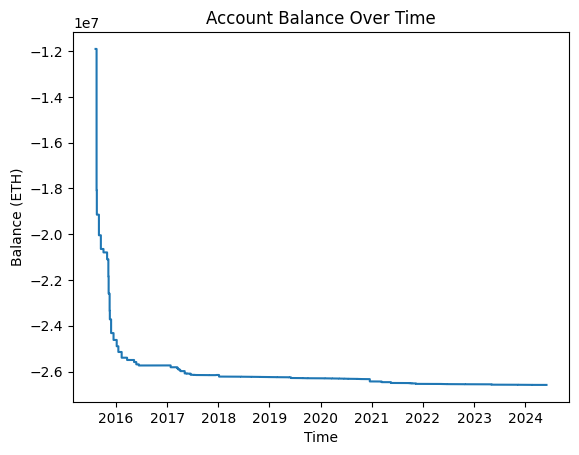

Final Account Balance: 309273.82359241357


In [ ]:
import requests
from datetime import datetime
import matplotlib.pyplot as plt

API_KEY = "US5BED19C5ZUM8ECBRSYFVHNAXDKEBADGB"
ADDRESS = "0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae"
BASE_URL = "https://api.etherscan.io/api"
ETHER_VALUE = 10 ** 18

def make_api_url(module, action, address, **kwargs):
    url = f"{BASE_URL}?module={module}&action={action}&address={address}&apikey={API_KEY}"
    for key, value in kwargs.items():
        url += f"&{key}={value}"
    return url

def get_account_balance(address):
    balance_url = make_api_url("account", "balance", address, tag="latest", x="2")
    with requests.Session() as session:
        response = session.get(balance_url)
    data = response.json()
    value = int(data["result"]) / ETHER_VALUE
    return value

def get_transactions(address):
    transactions = []
    page = 1
    while True:
        transactions_url = make_api_url("account", "txlist", address, startblock=0, endblock=99999999, page=page, offset=10000, sort="asc")
        with requests.Session() as session:
            response = session.get(transactions_url)
        data = response.json().get("result", [])
        if not data:
            break
        transactions.extend(data)
        page += 1
    return transactions

def get_internal_transactions(address):
    internal_transactions = []
    page = 1
    while True:
        internal_tx_url = make_api_url("account", "txlistinternal", address, startblock=0, endblock=99999999, page=page, offset=10000, sort="asc")
        with requests.Session() as session:
            response = session.get(internal_tx_url)
        data = response.json().get("result", [])
        if not data:
            break
        internal_transactions.extend(data)
        page += 1
    return internal_transactions

def plot_transactions(address):
    transactions = get_transactions(address)
    internal_transactions = get_internal_transactions(address)
    transactions.extend(internal_transactions)
    transactions.sort(key=lambda x: int(x["timeStamp"]))

    current_balance = 0
    balances = []
    times = []

    for tx in transactions:
        to = tx.get("to", "")
        from_addr = tx.get("from", "")
        value = float(tx.get("value", 0)) / ETHER_VALUE
        gas = float(tx.get("gasUsed", 0)) * float(tx.get("gasPrice", 0)) / ETHER_VALUE
        time = datetime.fromtimestamp(int(tx["timeStamp"]))
        money_in = to.lower() == address.lower()
        if money_in:
            current_balance += value
        else:
            current_balance -= value + gas
        balances.append(current_balance)
        times.append(time)

    plt.plot(times, balances)
    plt.xlabel("Time")
    plt.ylabel("Balance (ETH)")
    plt.title("Account Balance Over Time")
    plt.show()

address = "0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae"
plot_transactions(address)
eth = get_account_balance(address)
print("Final Account Balance:", eth)